In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from sklearn.metrics import r2_score
import seaborn as sns
from theano import tensor as tt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from nilearn import signal

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Please note that we rearranged the order of NMF components, or lesion atoms, in our publication,
i.e., according to hemisphere and anterior-posterior main weights.

Results may differ slightly in absolute terms given varying seeds.

In [2]:
Gasros = pd.read_csv("/.../BMH/Final_models/Gasros/Gasros_clinical_210111.csv", index_col=0)
lesions_absolute = pd.read_csv("/.../BMH/Final_models/Gasros/Gasros_lesiondata_210111.csv", index_col=0)

In [3]:
sex_idx = np.array(Gasros["Sex"])

In [4]:
n_components = 10
nmf = NMF(n_components=n_components, init='random', random_state=0)
lesions_nmf = nmf.fit_transform(np.log(lesions_absolute+1))

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


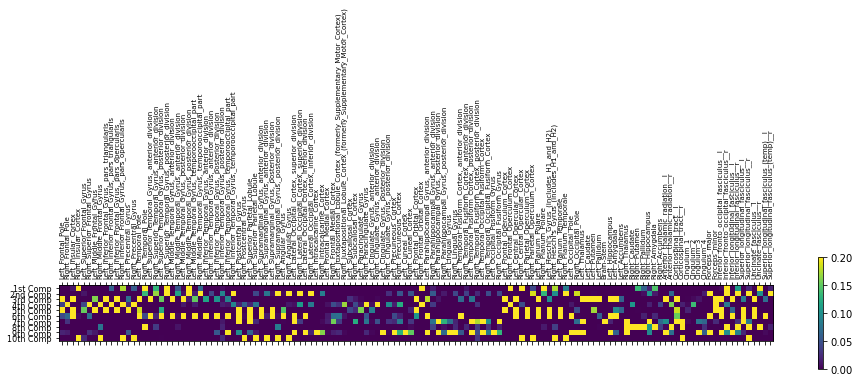

In [5]:
plt.matshow(nmf.components_,cmap='viridis')
plt.xticks(np.arange(0,len(lesions_absolute.columns)),lesions_absolute.columns,fontsize=7)
plt.xticks(rotation=90)
plt.yticks([0,1,2,3,4,5,6,7,8,9],['1st Comp','2nd Comp','3rd Comp','4th Comp','5th Comp','6th Comp','7th Comp','8th Comp','9th Comp','10th Comp',],fontsize=8)
plt.colorbar()
plt.clim(0, 0.2);
plt.tight_layout()
plt.show()


In [6]:
lesions_nmf_clean = signal.clean(np.array(lesions_nmf),detrend=False, standardize=False, confounds=[np.array(Gasros["Lesionload_scaled"])])

In [7]:
with pm.Model() as hierarchical_model:
    
    b_all = ["b_1", "b_2", "b_3", "b_4", "b_5", "b_6", "b_7", "b_8", "b_9", "b_10"]
    
    mu = pm.Normal("a", mu=0, sd=1)
    
    sigma_b_hyper = pm.HalfCauchy("sigma_b_hyper", 5, shape=1)
    
    sigma_b_all = pm.HalfCauchy("sigma_b_all", sigma_b_hyper, shape=2)
    
    mu_b_all_hyper = pm.Normal('mu_b_all_hyper', mu=0, sd=10, shape=1)
    mu_b_all = pm.Normal('mu_b_all', mu=mu_b_all_hyper, sd=10, shape=2)
    
    model_lower_vars = []
    for i_component in range(n_components):
            cur_beta = pm.Normal(b_all[i_component], mu=mu_b_all, sd=sigma_b_all, shape=2)
        
            mu = mu + cur_beta[sex_idx] * lesions_nmf_clean[:, i_component]
            model_lower_vars.append(cur_beta)

    cov1_beta = pm.Normal("cov1_age", mu=0, sd=10, shape=1)
    mu = mu + cov1_beta * np.array(Gasros["Age_scaled"])
    cov2_beta = pm.Normal("cov2_age2", mu=0, sd=10, shape=1)
    mu = mu + cov2_beta * np.array(Gasros["Age_scaled_2"])
    cov3_beta = pm.Normal("cov3_sex", mu=0, sd=1, shape=1)
    mu = mu + cov3_beta * np.array(Gasros["Sex"])
    
    cov4_beta = pm.Normal("cov4_hypertension", mu=0, sd=1, shape=1)
    mu = mu + cov4_beta * np.array(Gasros["HTN"])
    cov5_beta = pm.Normal("cov5_dm", mu=0, sd=1, shape=1)
    mu = mu + cov5_beta * np.array(Gasros["DM2"])
    cov6_beta = pm.Normal("cov6_af", mu=0, sd=1, shape=1)
    mu = mu + cov6_beta * np.array(Gasros["AF"])
    cov7_beta = pm.Normal("cov7_cad", mu=0, sd=1, shape=1)
    mu = mu + cov7_beta * np.array(Gasros["CAD"])
    cov8_beta = pm.Normal("cov8_wmh", mu=0, sd=1, shape=1)
    mu = mu + cov8_beta * np.array(Gasros["WMH_scaled"])

    
    # Model error
    eps = pm.HalfCauchy('eps',20)
    # Data likelihood
    NIHSS_like = pm.Normal('NIHSS_like', mu=mu, sd=eps, observed=np.array(Gasros["NIHSS"]))

In [8]:
#with hierarchical_model:
 #   hierarchical_trace = pm.sample(draws=5000, n_init=1000, random_seed=1, chains=1)
#pm.save_trace(hierarchical_trace, "/.../BMH/Final_models/Gasros/Main_hierarchical_NIHSS_0111.trace")

In [9]:
with hierarchical_model:
    hierarchical_trace = pm.load_trace("/.../BMH/Final_models/Gasros/Main_hierarchical_NIHSS_0111.trace")

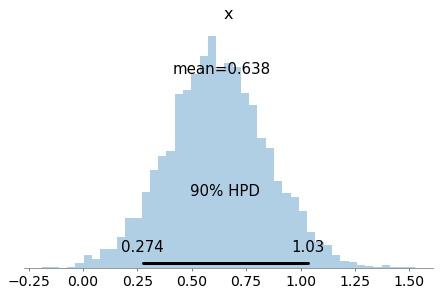

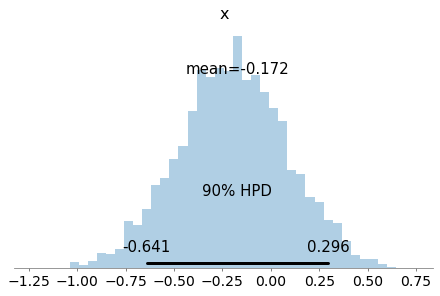

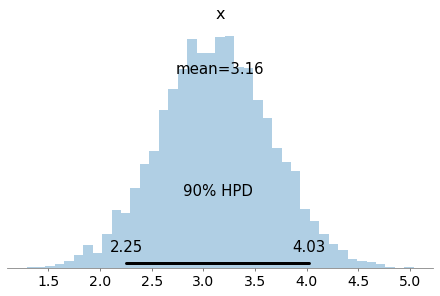

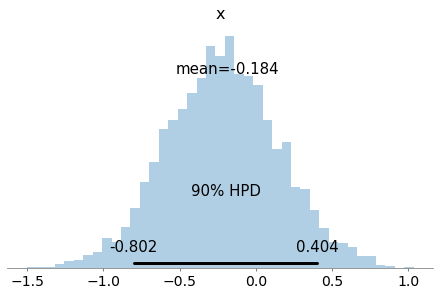

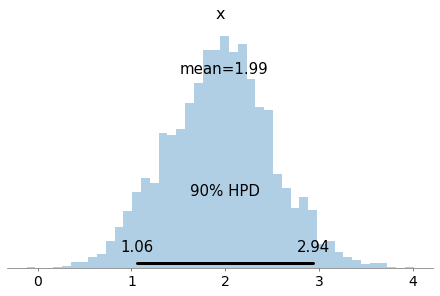

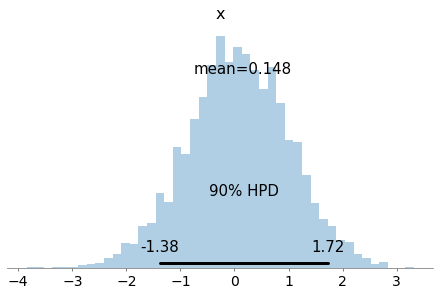

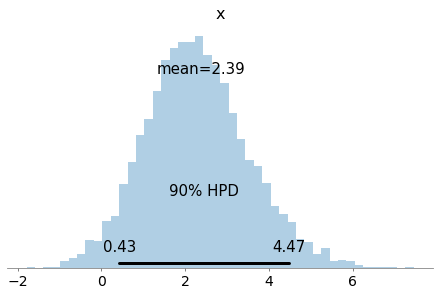

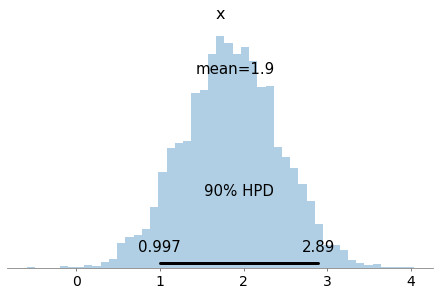

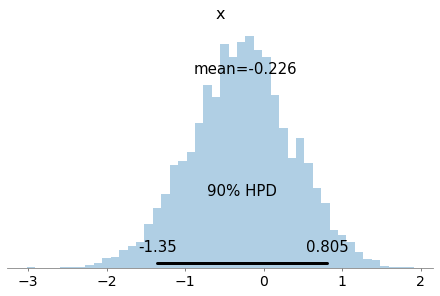

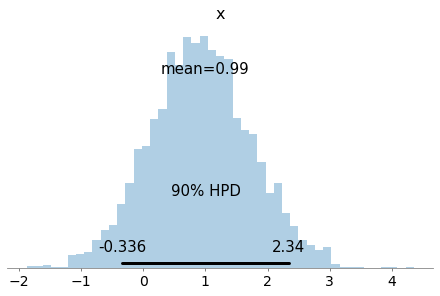

In [10]:
# Only men
for i in range(1, 11):
    pm.plot_posterior(hierarchical_trace[1000:]['b_%i' % i][:,0],round_to=3, kind='hist', credible_interval=0.9)
    


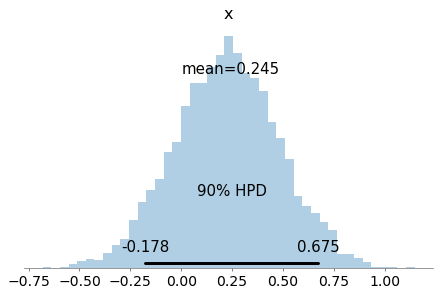

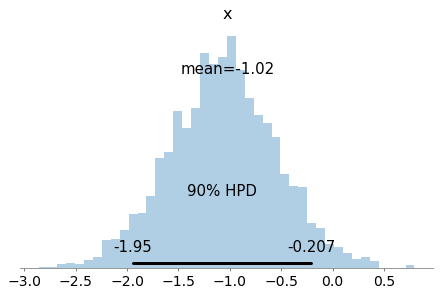

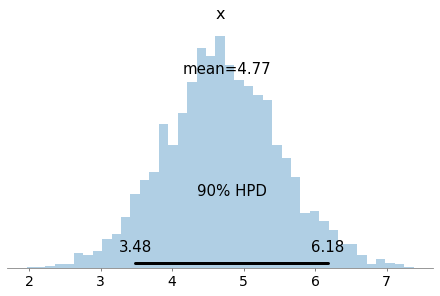

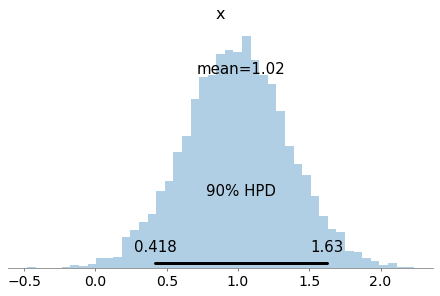

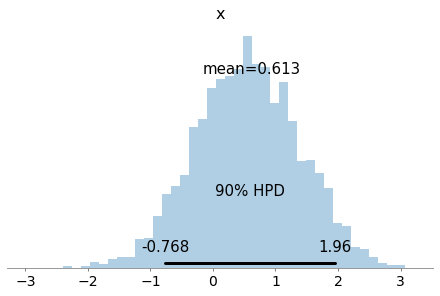

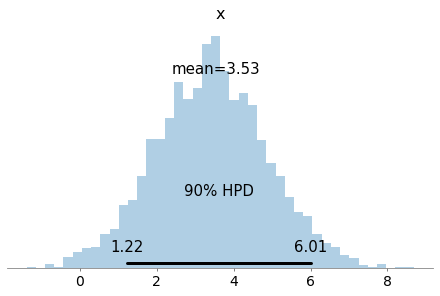

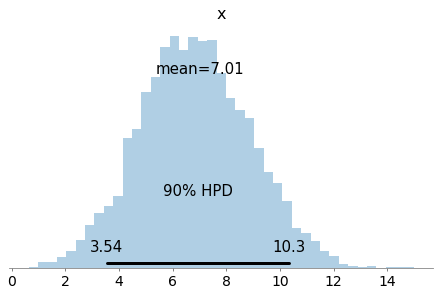

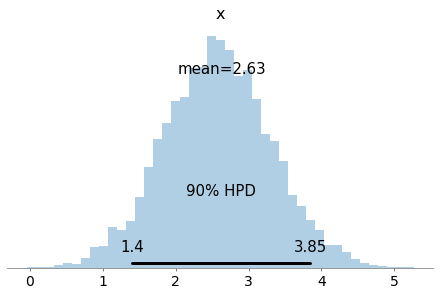

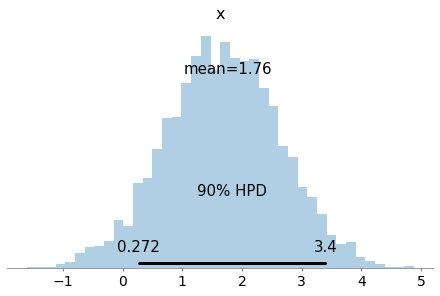

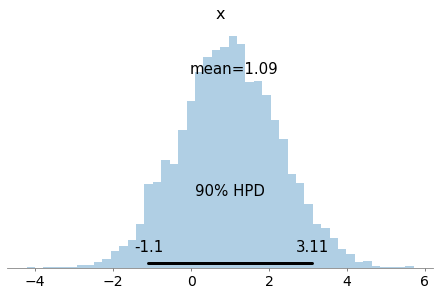

In [11]:
# Only women
for i in range(1, 11):
    pm.plot_posterior(hierarchical_trace[1000:]['b_%i' % i][:,1],round_to=3, kind='hist', credible_interval=0.9)


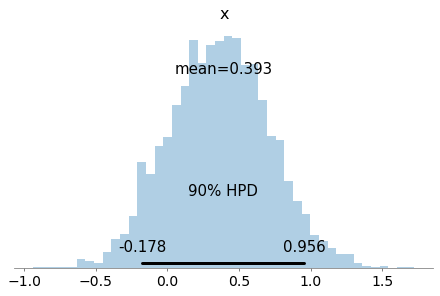

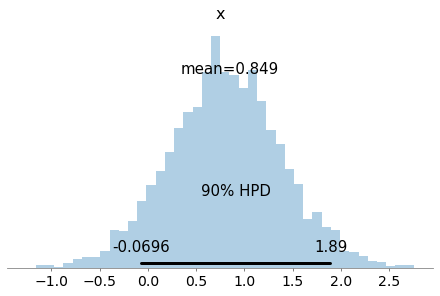

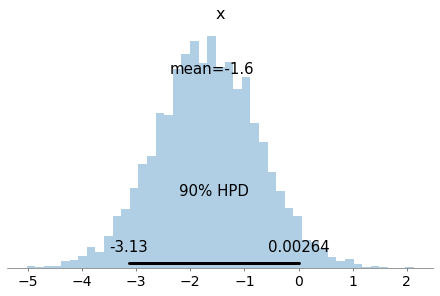

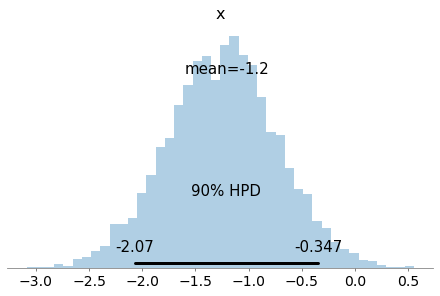

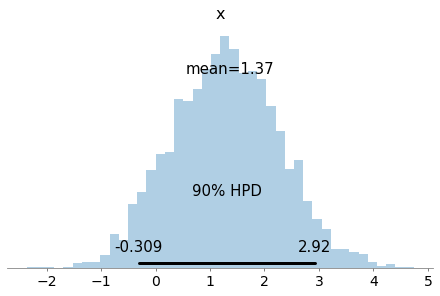

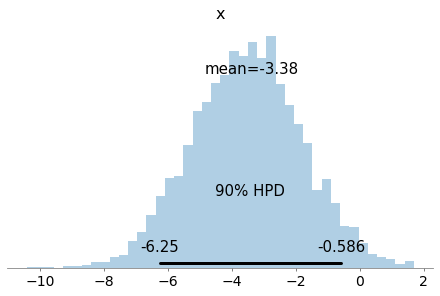

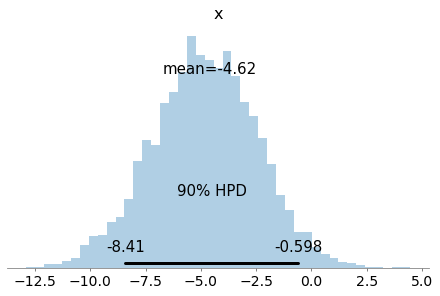

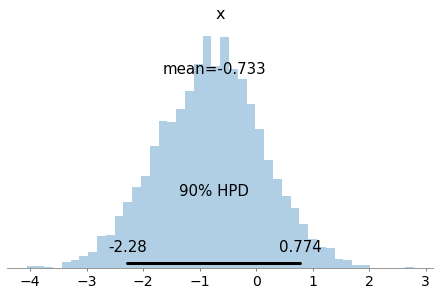

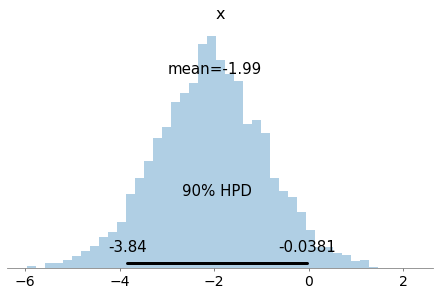

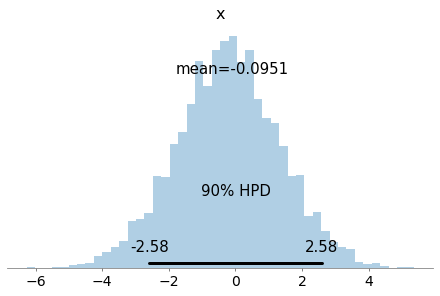

In [12]:
# Difference distribution: Men - Women
for i in range(1, 11):
    fig = pm.plot_posterior((hierarchical_trace[1000:]['b_%i' % i][:,0] - hierarchical_trace[1000:]['b_%i' % i][:,1]),round_to=3, kind='hist', credible_interval=0.9)

In [13]:
lesions_absolute =  lesions_absolute.rename(columns={"Left_Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)": "Left_Supplementary_Motor_Cortex", "Left_Heschl's_Gyrus_(includes_H1_and_H2)": "Left Heschl's Gyrus"})
lesions_absolute =  lesions_absolute.rename(columns={"Right_Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)": "Right_Supplementary_Motor_Cortex", "Right_Heschl's_Gyrus_(includes_H1_and_H2)": "Right Heschl's Gyrus"})
area_labels = []
for n in range(len(lesions_absolute.columns)):
    area_labels.append(lesions_absolute.columns[n].replace("_", " "))
for n in range(len(lesions_absolute.columns)):
    area_labels[n] = area_labels[n].replace("Right ", "")
    area_labels[n] = area_labels[n].replace("Left ", "")
    area_labels[n] = area_labels[n].replace("  r", "")
    area_labels[n] = area_labels[n].replace("  l", "")

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 2160x1440 with 0 Axes>

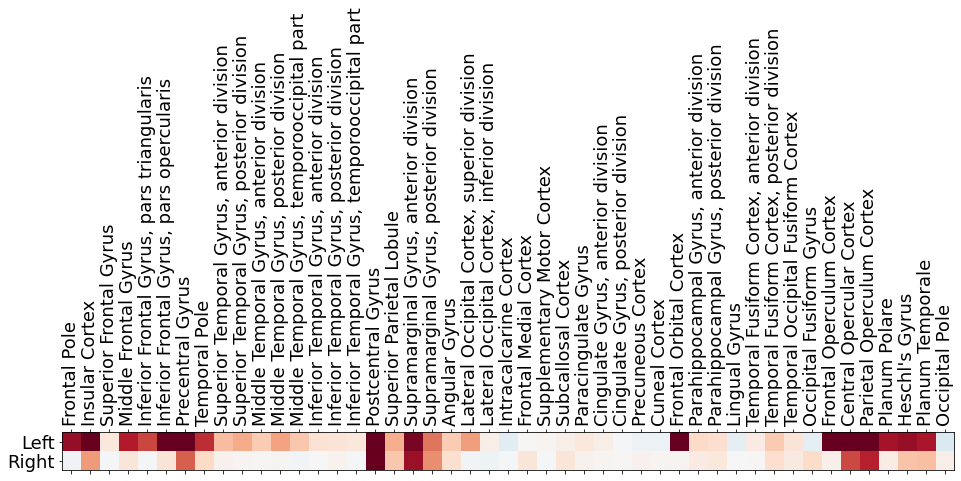

In [14]:
# men
b_left = []
b_left_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_left.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[0].mean())
    b_left_nmf.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[0].mean() * nmf.components_[i_nmf])
b_left = np.array(b_left)


b_left_inverse = nmf.inverse_transform(b_left)

b_inverse_helper = pd.DataFrame(b_left_inverse)
b_inverse = b_inverse_helper.loc[np.arange(0,94,2)]
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = np.array(b_inverse_helper.loc[np.arange(1,94,2)])


plt.figure(figsize=(30,20))
plt.matshow(np.array(b_inverse.transpose()),cmap='RdBu_r')
plt.xticks(np.arange(0,len(lesions_absolute.columns[np.arange(1,94,2)])),np.array(area_labels)[np.arange(1,94,2)],fontsize=18)
plt.xticks(rotation=90)
#plt.yticks([0, 1],['Left hemisphere', 'Right hemisphere'],fontsize=16)
plt.yticks([0, 1],['Left', 'Right'],fontsize=18)
plt.clim(-3, 3);
plt.tight_layout()
plt.show()

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 2160x1440 with 0 Axes>

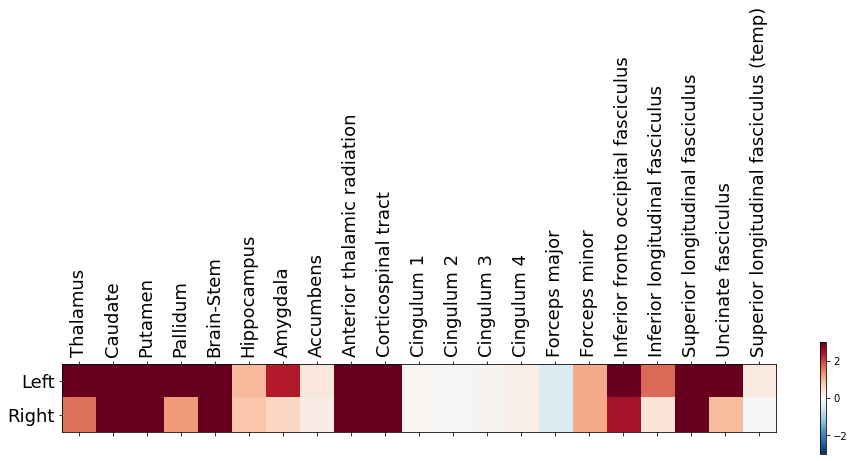

In [15]:
# men
b_left = []
b_left_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_left.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[0].mean())
    b_left_nmf.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[0].mean() * nmf.components_[i_nmf])
b_left = np.array(b_left)


b_left_inverse = nmf.inverse_transform(b_left)

b_inverse_helper = pd.DataFrame(b_left_inverse)
b_inverse = pd.concat([b_inverse_helper.loc[94:101],b_inverse_helper.loc[np.arange(109,112,2)],b_inverse_helper.loc[113:118],b_inverse_helper.loc[np.arange(119,126,2)],b_inverse_helper.loc[127]])
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = np.array(pd.concat([pd.concat([b_inverse_helper.loc[102:105],b_inverse_helper.loc[98],b_inverse_helper.loc[106:108],b_inverse_helper.loc[np.arange(110,113,2)],b_inverse_helper.loc[113:118],b_inverse_helper.loc[np.arange(120,127,2)],b_inverse_helper.loc[128]])]))

labels = np.concatenate([np.array(area_labels)[94:102],np.array(area_labels)[np.arange(109,112,2)],np.array(area_labels)[113:119],np.array(area_labels)[np.arange(119,126,2)],np.array(area_labels)[127:]]) 
labels = labels[:-1]                                                                                                                          
plt.figure(figsize=(30,20))
plt.matshow(np.array(b_inverse.transpose()),cmap='RdBu_r')
plt.xticks(np.arange(0,len(labels)),labels,fontsize=18)
plt.xticks(rotation=90)
plt.yticks([0, 1],['Left', 'Right'],fontsize=18)
plt.colorbar()
plt.clim(-3, 3);
plt.tight_layout()
plt.show()

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 2160x1440 with 0 Axes>

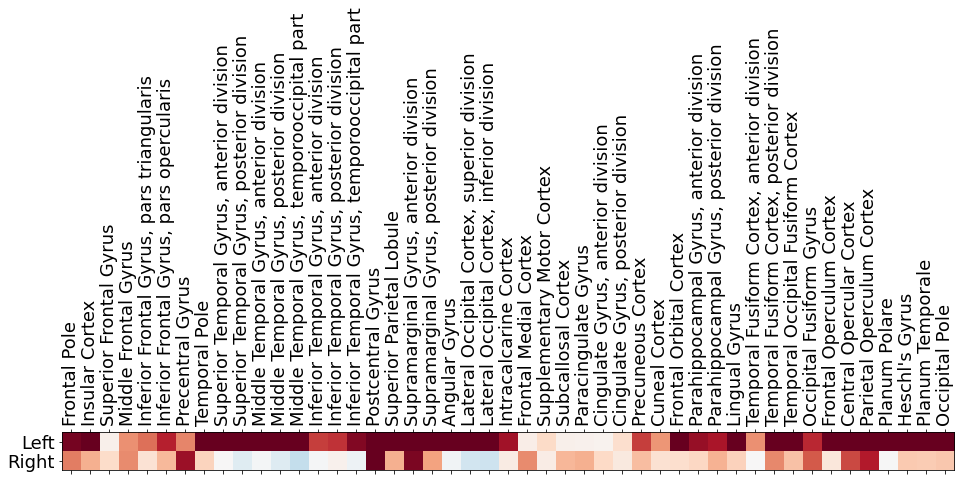

In [16]:
# women
b_left = []
b_left_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_left.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[1].mean())
    b_left_nmf.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[1].mean() * nmf.components_[i_nmf])
b_left = np.array(b_left)


b_left_inverse = nmf.inverse_transform(b_left)

b_inverse_helper = pd.DataFrame(b_left_inverse)
b_inverse = b_inverse_helper.loc[np.arange(0,94,2)]
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = np.array(b_inverse_helper.loc[np.arange(1,94,2)])


plt.figure(figsize=(30,20))
plt.matshow(np.array(b_inverse.transpose()),cmap='RdBu_r')
plt.xticks(np.arange(0,len(lesions_absolute.columns[np.arange(1,94,2)])),np.array(area_labels)[np.arange(1,94,2)],fontsize=18)
plt.xticks(rotation=90)
plt.yticks([0, 1],['Left', 'Right'],fontsize=18)
#plt.colorbar()
plt.clim(-3, 3);
plt.tight_layout()
plt.show()

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 2160x1440 with 0 Axes>

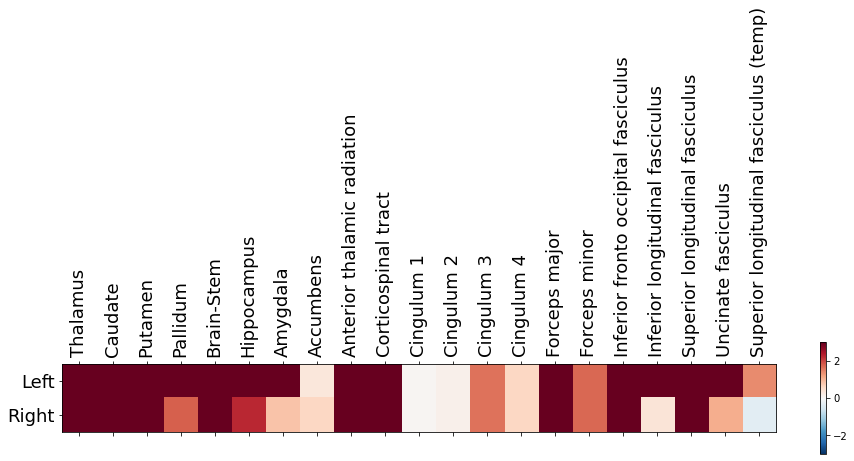

In [17]:
# women
b_left = []
b_left_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_left.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[1].mean())
    b_left_nmf.append(pd.DataFrame(hierarchical_trace[1000:]["b_%i" %i])[1].mean() * nmf.components_[i_nmf])
b_left = np.array(b_left)


b_left_inverse = nmf.inverse_transform(b_left)

b_inverse_helper = pd.DataFrame(b_left_inverse)
b_inverse = pd.concat([b_inverse_helper.loc[94:101],b_inverse_helper.loc[np.arange(109,112,2)],b_inverse_helper.loc[113:118],b_inverse_helper.loc[np.arange(119,126,2)],b_inverse_helper.loc[127]])
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = np.array(pd.concat([pd.concat([b_inverse_helper.loc[102:105],b_inverse_helper.loc[98],b_inverse_helper.loc[106:108],b_inverse_helper.loc[np.arange(110,113,2)],b_inverse_helper.loc[113:118],b_inverse_helper.loc[np.arange(120,127,2)],b_inverse_helper.loc[128]])]))

labels = np.concatenate([np.array(area_labels)[94:102],np.array(area_labels)[np.arange(109,112,2)],np.array(area_labels)[113:119],np.array(area_labels)[np.arange(119,126,2)],np.array(area_labels)[127:]]) 
labels = labels[:-1]                                                                                                                            
plt.figure(figsize=(30,20))
plt.matshow(np.array(b_inverse.transpose()),cmap='RdBu_r')
plt.xticks(np.arange(0,len(labels)),labels,fontsize=18)
plt.xticks(rotation=90)
plt.yticks([0, 1],['Left', 'Right'],fontsize=18)
plt.colorbar()
plt.clim(-3, 3);
plt.tight_layout()
plt.show()